In [82]:
import qtensor as qtn
import quimb.tensor 
import quimb as qmb
import cotengra as ctg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import opt_einsum
import time

from cartesian_explorer import Explorer

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def test_circ(backend='qtn', N=10, p=3):
    graph = qtn.toolbox.random_graph(nodes=N, degree=3, seed=10)
    gamma, beta = [0.1]*p, [0.3]*p
    if backend=='qtn':
        composer = qtn.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
        composer.ansatz_state()
        return composer.circuit
    elif backend=='qmb':
        terms = {(i, j):1 for i, j in graph.edges}
        circ = qmb.tensor.circ_qaoa(terms, p, gamma, beta)
        return circ

## Generate circuit for MaxCut ansatz

In [129]:
N = 34
qmb_circ = test_circ(backend='qmb', N=N, p=3)
qtn_circ = test_circ(backend='qtn', N=N, p=3)

len(qmb_circ.gates), len(qtn_circ)

(289, 289)

## Optimize circuit

In [130]:
ctg.list_hyper_functions()

['betweenness',
 'flowcutter',
 'greedy',
 'kahypar',
 'labelprop',
 'labels',
 'quickbb',
 'spinglass',
 'walktrap']

In [131]:
from qtensor.optimisation.Optimizer import OrderingOptimizer

In [132]:
max_opt_repeats = 16

In [133]:
%%time
# Runs faster
qmb_opt = ctg.HyperOptimizer(
    methods=['greedy']
    , optlib='baytune'
    , max_repeats=max_opt_repeats
)
#qmb_opt = ctg.HyperOptimizer(max_repeats=32)
# for some reason gives even better contraciton, 13 for N=20
#rehs = qmb_circ.amplitude_rehearse(optimize=qmb_opt, simplify_sequence='D')
rehs = qmb_circ.amplitude_rehearse(optimize=qmb_opt)
qmb_tn = rehs['tn']
qmb_tw = rehs['W']
print('Quimb treewidth:', qmb_tw)

Quimb treewidth: 23.0
CPU times: user 2.27 s, sys: 2.97 s, total: 5.24 s
Wall time: 1.08 s


In [134]:
%%time
qtn_opt = qtn.optimisation.RGreedyOptimizer(temp=0.02, repeats=max_opt_repeats)
#qtn_opt = OrderingOptimizer()

qtn_tn = qtn.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(qtn_circ)
peo, _ = qtn_opt.optimize(tn)

qtn_tw = qtn_opt.treewidth
print('Qtensor treewidth', qtn_tw)

Qtensor treewidth 24
CPU times: user 724 ms, sys: 229 ms, total: 953 ms
Wall time: 649 ms


In [135]:
qmb_tree = ctg.ContractionTree.from_info(rehs['info'])
print(f"Quimb flops: {qmb_tree.total_flops():,}")
print(f"Quimb Largest tensor {rehs['info'].largest_intermediate:,}")

Quimb flops: 1,198,653,520
Quimb Largest tensor 8,388,608


In [136]:
mems, flops = tn.simulation_cost(peo)
print(f'Qtensor flops {sum(flops):,}')
print(f'Qtensor all tensors memory {max(mems):,}')

Qtensor flops 426,326,882
Qtensor all tensors memory 25,165,826


### Simulate and compare times

In [137]:
start = time.time()
qmb_circ.amplitude([0]*N, optimize=qmb_tree.path())
end = time.time()
print('Quimb time to solution', end-start)
print(f'Quimb Gflops {qmb_tree.total_flops()/(end-start)/1e9:,}')

Quimb time to solution 15.275545120239258
Quimb Gflops 0.0784687885482954


In [138]:
start = time.time()
sim = qtn.QtreeSimulator()
sim.simulate_batch(qtn_circ, peo=peo)
end = time.time()
print('Qtensor time to solution', end-start)
print(f'Qtensor Gflops {sum(flops)/(end-start)/1e9:,}')

Qtensor time to solution 1.5306243896484375
Qtensor Gflops 0.278531352880063


## Compare tensor networks to be isomorphic

In [140]:
qmb_tn.tensors

(Tensor(shape=(2, 2), inds=('_2121ccAAJtV', '_2121ccAAJth'), tags=oset(['RZZ', 'GATE_35', 'ROUND_0', 'I4', 'I10'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJtT', '_2121ccAAJuP'), tags=oset(['RZZ', 'GATE_45', 'ROUND_0', 'I3', 'I27'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJuB', '_2121ccAAJuT'), tags=oset(['RZZ', 'GATE_49', 'ROUND_0', 'I20', 'I29'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJtd', '_2121ccAAJtl'), tags=oset(['RZZ', 'GATE_54', 'ROUND_0', 'I8', 'I12'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJtl', '_2121ccAAJtp'), tags=oset(['RZZ', 'GATE_56', 'ROUND_0', 'I12', 'I14'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJtN', '_2121ccAAJuN'), tags=oset(['RZZ', 'GATE_59', 'ROUND_0', 'I0', 'I26'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJtN', '_2121ccAAJuP'), tags=oset(['RZZ', 'GATE_60', 'ROUND_0', 'I0', 'I27'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJtP', '_2121ccAAJub'), tags=oset(['RZZ', 'GATE_64', 'ROUND_0', 'I1', 'I33'])),
 Tensor(shape=(2, 2), inds=('_2121ccAAJtP', '_2121ccAAJtz'), t

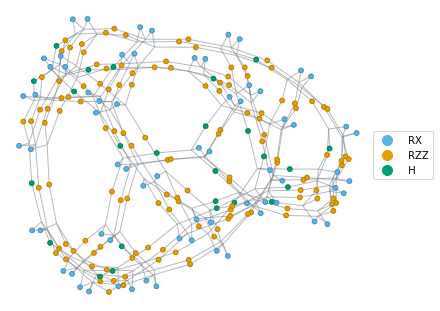

In [141]:
qmb_tn.draw(color=['RX', 'RZZ', 'H'])


In [142]:
lg = ctg.core.LineGraph(tree.inputs, tree.output)
qmb_lg = nx.Graph()
qmb_lg.add_edges_from(lg.edges)

NameError: name 'tree' is not defined

In [ ]:
nx.draw_kamada_kawai(qmb_lg)

In [143]:
import qtree

In [144]:
qtn_lg = tn.get_line_graph()

(array([ 68.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 102.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

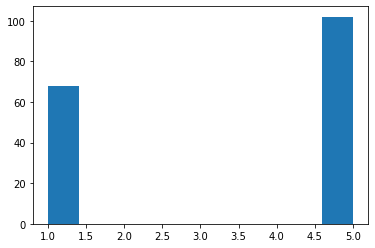

In [145]:
qtn_lg.remove_edges_from(nx.selfloop_edges(qtn_lg))
plt.hist(list(zip(*qtn_lg.degree))[1])

In [146]:
qtn_lg.remove_edges_from(nx.selfloop_edges(qtn_lg))
degs = list(qtn_lg.degree)
for node, deg in degs:
    if deg < 3:
        qtn_lg.remove_node(node)

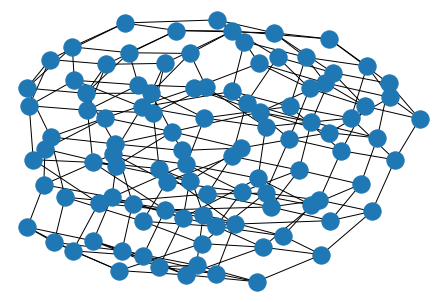

In [147]:
nx.draw_kamada_kawai(qtn_lg)

(array([68.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 34.]),
 array([4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ]),
 <BarContainer object of 10 artists>)

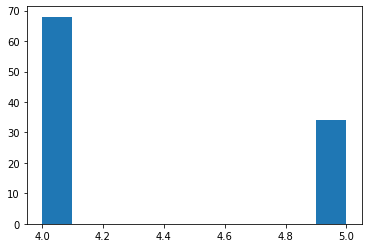

In [103]:
plt.hist(list(zip(*qtn_lg.degree))[1])

In [62]:
nx.is_isomorphic(qtn_lg, qmb_lg)

True

## (Work in progress) Move ordering from qtensor to quimb

In [165]:
qtn_opt = qtn.optimisation.RGreedyOptimizer(temp=0.02, repeats=10)
qtn_tn = qtn.optimisation.TensorNet.QtreeTensorNet.from_qtree_gates(qtn_circ)
qtn_peo, _ = qtn_opt.optimize(qtn_tn)
qtn_peo[:5]

[i_0, i_1, i_2, i_3, i_4]

In [163]:
def ctg_tree_qtn_order(tree, qtn_tn, qtn_peo):
    qtn_lg = qtn_tn.get_line_graph()
    qtn_lg.remove_edges_from(nx.selfloop_edges(qtn_lg))
    
    degs = list(qtn_lg.degree)
    small_nodes = []
    for node, deg in degs:
        if deg < 3:
            small_nodes.append(node)
            qtn_lg.remove_node(node)
    # Simplify the graph, and remove the nodes that simplified from peo,
    # then create an node->int mapping based on order of indices
    peo_stripped = [n for n in qtn_peo if n not in small_nodes]
    #peo_stripped = [n for n in peo_stripped if n not in qtn_tn.ket_vars+qtn_tn.bra_vars ]
    print(small_nodes)
    ## FIXME:
    # This will not work, since the peo contains bra_vars and ket_vars,
    # and the line graph does not contain it.
    # 
    # What is the reason to leave out those variables in the first place?
    # Need a systematic approach on how to simplify the graph
    ##
    # Excerpt from qtree/simulator.py
    #
    #     # Get PEO
    #     peo_initial, treewidth = gm.get_peo(graph)

    #     # transform peo so free_bra_vars and free_ket_vars are at the end
    #     # this fixes the layout of the tensor
    #     peo = gm.get_equivalent_peo(graph, peo_initial,
    #                                 free_bra_vars+free_ket_vars)

    #     # place bra and ket variables to beginning, so these variables
    #     # will be contracted first
    peo_map = {n:i for i, n in enumerate(qtn_lg.nodes)}
    peo_ints = [peo_map[n] for n in peo_stripped]
    qmb_lg = ctg.core.LineGraph(tree.inputs, tree.output)
    # The assumption is that qmb_lg has the same node labeling as qtn_lg,
    # which can be very much not true.
    qmb_peo_map = {i:k for i, k in enumerate(qmb_lg.nodes)}
    qmb_peo = [qmb_peo_map[i] for i in peo_ints]
    
    return ctg.ContractionTree.from_edge_path(qtn_peo, tree.inputs, tree.output, tree.size_dict) 

ctg_tree_qtn_order(qmb_tree, qtn_tn, qtn_peo)

[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 172, 184, 197, 187, 186, 176, 198, 188, 189, 181, 171, 190, 196, 177, 170, 173, 192, 185, 193, 201, 194, 202, 179, 203, 191, 195, 174, 183, 178, 200, 175, 180, 182, 199]


KeyError: i_0